In [1]:
%matplotlib inline
import math

import numpy as np
import matplotlib.pyplot as plt

from linalg_helper import project, make_random_subspace, make_random_direction, make_symmetric_matrix

plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
# x[t + 1] = Ax[t] + u[t]
def single_test(strategy, A, x, steps, dims=1, gen_subspace=make_random_subspace, debug=False):
    N = A.shape[0]
   
    states = [x]
    estimates = []
    
    for _ in range(steps):
        random_span = gen_subspace(N, dims)
        random_projection = project(x, random_span)
        strat = strategy(random_projection)
        u = strat["action"]
        x = A @ x + u
        if debug:
            print("state:", x)
            print("action:", u)
            print("estimate:", strat.get("best_estimate", None))
        states.append(x)
        estimates.append(strat.get("best_estimate", None))
    
    return {"states": states, "estimates": estimates}

In [3]:
def plot_magnitude_decay(**kwargs):
    for name, vecs in kwargs.items():
        vals = [np.linalg.norm(vec) for vec in vecs]
        plt.plot(range(len(vecs)), vals, label=name)
    plt.xlabel("steps")
    plt.ylabel("magnitudes")
    plt.yscale('log')
    plt.legend()
    
def plot_ev_error(reference, candidates):
    errors = []
    for candidate in candidates:
        errors.append(np.linalg.norm(candidate - reference))
    plt.plot(range(len(errors)), errors, label="errors")
    plt.xlabel("steps")
    plt.ylabel("error")
    plt.yscale("log")
    plt.legend()
        
def plot_states(states):
    states = np.array(states)
    plt.quiver([0], [0], states[:, 0], states[:, 1])
    plt.xlabel("steps")
    plt.ylabel("error")
    plt.legend()

In [4]:
def greedy(vec):
    return {"action": -vec}

def zero(vec):
    return {"action": np.zeros(len(vec))}

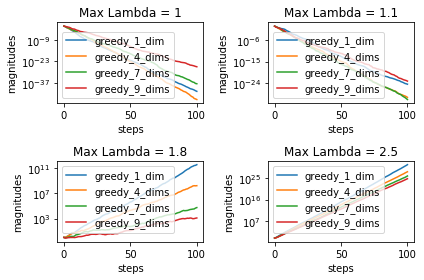

In [5]:
# Effect of more dimensions on growth / decay
N = 10

lambdas = [1, 1.1, 1.8, 2.5]
for i, max_lambda in enumerate(lambdas):
    A = make_symmetric_matrix(N, max_lambda, 0.1)
    x0 = make_random_direction(N)
    plt.subplot(math.ceil(len(lambdas) / 2), 2, i + 1)
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.title(f"Max Lambda = {max_lambda}")
    plot_magnitude_decay(
        greedy_1_dim=single_test(greedy, A, x0, 100, 1)["states"],   
        greedy_4_dims=single_test(greedy, A, x0, 100, 2)["states"],
        greedy_7_dims=single_test(greedy, A, x0, 100, 3)["states"],
        greedy_9_dims=single_test(greedy, A, x0, 100, 4)["states"],
    )
    plt.rcParams['figure.figsize'] = [5, 5]

plt.tight_layout()
plt.legend()
plt.show()

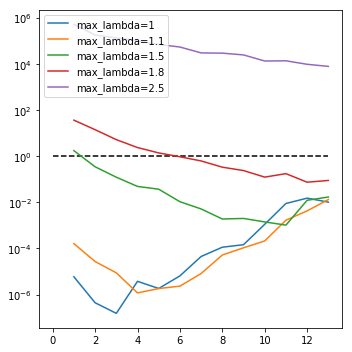

In [7]:
# Effect of max eigenvalue on minimum number of dimensions needed to ensure stability
N = 20
trials = 3

max_dims = 13

lambdas = [1, 1.1, 1.5, 1.8, 2.5]
for i, max_lambda in enumerate(lambdas):
    A = make_symmetric_matrix(N, max_lambda, 0.1)
    x0 = make_random_direction(N)
    scalings = []
    for dims in range(1, max_dims+1):
        scaling_sum = 0
        for trial in range(trials):
            states = single_test(greedy, A, x0, 20, dims)["states"]
            scaling_sum += np.linalg.norm(states[-1])
        scalings.append(scaling_sum / trials)
    plt.plot(range(1, max_dims+1), scalings, label=f"max_lambda={max_lambda}")

plt.hlines(y=1, xmin=0, xmax=max_dims, linestyle="dashed")
    
plt.yscale("log")
plt.tight_layout()
plt.legend()
plt.show()

In [8]:
""" 
Assume that the main eigenvector dominates. 
Assume that this eigenvector lies in the span of the measurements made so far, and use least squares to compute it
Also need to determine the value of lambda
"""
def make_least_squares(lambd, k0, dim):
    d = []
    alpha = []
    w = np.zeros(dim)
    i = 0
    def strategy(vec):
        nonlocal i, w
        
        w = lambd * w # this assumes that we can measure Ax[i], though we can only actually measure x[i]
        
        y = np.linalg.norm(vec)
        m = sum(a * b for a, b in zip(alpha, (w @ d_i for d_i in d))) + lambd ** (i+1) * k0 # i + 1 -> i
        
        alpha_i = y / m
        alpha.append(alpha_i)
        d.append(vec / y)
        
        x0_approx = np.sum(alpha_i * d_i for alpha_i, d_i in zip(alpha, d))
        x_approx = project(k0 * np.sum(alpha_i * d_i for alpha_i, d_i in zip(alpha, d)) * (lambd ** (i+1)) + w, 
                           x0_approx.reshape(-1, 1))  # i + 1 -> i
        if i < dim - 1:
            out = np.zeros(dim)
        else:
            out = -x_approx
        
#         out = np.zeros(dim)
                
#         w = lambd * w + out
        w = w + out
    
#         print("x0_approx:", x0_approx)
#         print("x_approx:", x_approx)
#         print("out:", out)
#         print("w:", w)
        
        i += 1
        return out
    
    return strategy

def yield_basis(mat, dim):
    i = 0
    def gen(*args):
        nonlocal i
        i += 1
        return mat[:, i - 1].reshape(-1, 1)
    return gen

In [9]:
""" 
Assume that the main eigenvector dominates. 
Assume that this eigenvector lies in the span of the measurements made so far, and use least squares to compute it
Also need to determine the value of lambda
"""

WAIT_FACTOR = 500

def make_least_squares(lambd, k0, dim):
    d = []  # assume observations are identity
    eqns = None
    observations = None
    w = np.zeros(dim)
    i = 0
    
    def strategy(vec):
        nonlocal i, eqns, observations
        # w is initialized to lambda^(i-1)u[0] + ... + lambda u[i - 1]

        if i < dim * WAIT_FACTOR:
            # do nothing, just observe system
            y = np.linalg.norm(vec)
            alpha_i_est = y / lambd ** i / k0
            new_eqn = np.array([0] * (i % dim) + [1] + [0] * (dim - (i % dim) - 1)).reshape(1, -1)
            eqns = np.vstack([eqns, new_eqn]) if eqns is not None else new_eqn
            observations = np.vstack([observations, [alpha_i_est]]) if observations is not None else [alpha_i_est]
        else:
            raise Exception("???")

        best_estimate = np.linalg.lstsq(eqns, observations)[0].T
        best_estimate = best_estimate / np.linalg.norm(best_estimate)
        
        i += 1
        return {"action": np.zeros(dim), "best_estimate": best_estimate}
    
    return strategy

/Users/rahularya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/rahularya/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/rahularya/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:2054: RuntimeWarning: overflow encountered in square
  resids = sum(r_parts**2, axis=-2)


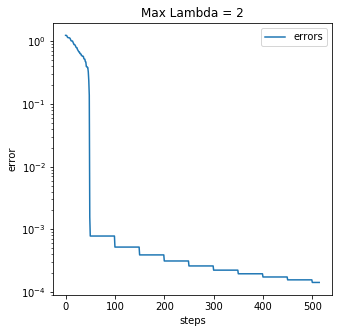

In [11]:
# Trying the new approach
N = 50

lambdas = [2]#, 1.1, 1.5, 1.8, 2.5]
# plt.rcParams['figure.figsize'] = [10, 10]
for i, max_lambda in enumerate(lambdas):
    A = make_symmetric_matrix(N, max_lambda, 0.02, exact=True)
#     x0 = make_random_direction(N)
    x0 = A @ make_random_direction(N)
    ev = np.linalg.matrix_power(A, 100) @ x0
    ev /= np.linalg.norm(ev)
#     print(f"ev = {ev}")
#     print(f"lambdas:{np.linalg.eig(A)[0]}")
#     print("x0:", x0)
#     print("x0:", x0)
#     print(f"A={A}")
#     print("x0_norm:", x0 / np.linalg.norm(x0))
#     plt.subplot(math.ceil(len(lambdas) / 2), 2, i + 1)
    plt.title(f"Max Lambda = {max_lambda}")
    response = single_test(make_least_squares(max_lambda, np.linalg.norm(x0), N),
                           A, x0, N*20, max_lambda, 
#                            yield_basis(make_random_subspace(N, N), N))["states"],   
                           yield_basis(np.hstack([np.eye(N)]*10000), N),
                          debug=False)
#     plot_magnitude_decay(greedy_1_dim=response["states"])
    plot_ev_error(ev, response["estimates"])
#     print(np.linalg.norm(response["estimates"][-1] - ev))

plt.legend()
plt.show()
plt.rcParams['figure.figsize'] = [5, 5]